Ez egy konvolúciós neurháló, ahol ugyanazok a downsampling lépések és az upsampling lépések. Emellett minden méretből skippelünk egy layert az upsamplinghez, és ott összekonkatenáljuk őket.

![alt text](https://miro.medium.com/max/2824/1*f7YOaE4TWubwaFF7Z1fzNw.png)

Az importot nem részletezem, mert teljesen felesleges tudni.

Ez a kód épít a Convolution NN kód kommentjeire.

In [2]:
#import

import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt

#for the operational system oppurtunities
import os 


#load the data

!pip install -U -q pyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import  GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

f = drive.CreateFile({'id': '1XeuSYBk2PPwEX7GWKyytc8ySggPkkYiB'})
f.GetContentFile('data.zip')
! unzip data.zip

def load_data(path):
  return np.load(os.path.join(path, 'train_img.npy')), \
  np.load(os.path.join(path, 'train_mask.npy')), \
  np.load(os.path.join(path, 'test_img.npy')), \
  np.load(os.path.join(path, 'test_mask.npy'))

train_img, train_mask, test_img, test_mask = load_data('./')

Archive:  data.zip
  inflating: train_img.npy           
  inflating: test_img.npy            
  inflating: train_mask.npy          
  inflating: test_mask.npy           


(2975, 48, 48, 3)
Iteration: 0, loss: 91.81167
Iteration: 100, loss: 33.50456
Iteration: 200, loss: 32.0528
Iteration: 300, loss: 22.571354
Iteration: 400, loss: 27.714098
Iteration: 500, loss: 29.655485
Iteration: 600, loss: 30.703775
Iteration: 700, loss: 31.424675
Iteration: 800, loss: 28.801134
Iteration: 900, loss: 28.13053


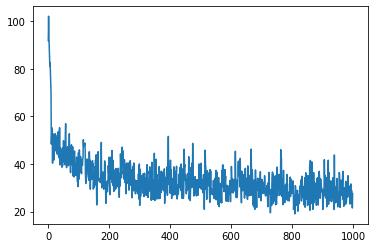

In [5]:
#finding the data and the mask shapes

#itt láthatjuk hogy van egy 2975 darabos 48*48as rgb-s képünk (rgbDim = 3)
#és most nem nézzük meg a label alakját, mert a u-netnél ugyanannak kell lennie mint az inputnak
print(train_img.shape)

#ha valakit érdekel hogy hogy néz ki az input és a mask itt ki lehet printelni
#fig = plt.figure(figsize = (8,7))
#ax = fig.subplots(nrows = 1, ncols = 2)
#ax[0].imshow(train_img[0, :] / 255)
#ax[1].imshow(train_mask[0, :] / 255)


#hyperparameters

input_shape = [48, 48, 3]
batch_size = 2
num_kernels = [input_shape[-1], 64, 128, 256, 512, 1024]
num_iterations = 1000


#graph building

tf.reset_default_graph()

#itt látszik hogy ugyanazt az alakot adtuk meg mindkettőnek
input_data = tf.placeholder(tf.float32, [batch_size] + input_shape)
expected_output = tf.placeholder(tf.float32, [batch_size] + input_shape)

current_input = input_data

#ez az üres tömb, ahol tárolni fogjuk a skippelendő layerünket
layers = []

#downsampling

for i in range(0, len(num_kernels)-1):
  with tf.variable_scope('downLayer' + str(i)):
    w = tf.get_variable('kernel', [3, 3, num_kernels[i], num_kernels[i+1]])
    b = tf.get_variable('b', [num_kernels[i+1]])

    current_input = tf.nn.conv2d(current_input, w, strides=[1,1,1,1], padding='SAME')
    current_input = tf.add(current_input, b)
    current_input = tf.nn.relu(current_input)

    #a legalsó layert nem akrjuk kimenteni és downsamplingelni se
    if(i != len(num_kernels)-2):
      layers.append(current_input)
      current_input = tf.nn.max_pool(current_input, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

#upsampling

for i in range(len(num_kernels)-1, 0, -1) :
  with tf.variable_scope('upLayer' + str(i)):

    #az utolsó layert nem akarjuk upsamplingelni
    if(i != 1):

      #upsamplingnél fordítva kell megadni a filter alakjának utolsó két paraméterét
      #valószínüleg azért van így kitalálva, mert ha mentett súlyokból dolgozunk mint az autoencoderbe, akkor nem kell átalakítani
      w = tf.get_variable('weights', [3, 3, num_kernels[i-1], num_kernels[i]])
      b = tf.get_variable('bias', [num_kernels[i-1]])

      #ez felel meg a maxpoolnak, tehát itt upsamplingelünk
      #annyi a paraméterek között a különbség hogy itt nem kernel méretet adunk meg hanem a várt output alakját
      current_input = tf.nn.conv2d_transpose(current_input, w, [batch_size, layers[i-2].shape[1], layers[i-2].shape[2], num_kernels[i-1]], strides=[1,2,2,1], padding='SAME')
      current_input = tf.add(current_input, b)
      current_input = tf.nn.relu(current_input)

      #végül összekonkatenáljuk az adott értékeket, és még meg kell adni a tengelyt is
      current_input = tf.concat([current_input, layers[i-2]], 3)

    #ez itt meg egy normal konvolúciós lépés ahol csökkentjük a kernel méretét
    #mivel a konkatenáció miatt duplájára nőtt
    w = tf.get_variable('kernel', [3, 3, num_kernels[i], num_kernels[i-1]])
    b = tf.get_variable('b', [num_kernels[i-1]])
    current_input = tf.nn.conv2d(current_input, w, strides=[1,1,1,1], padding='SAME')
    current_input = tf.add(current_input, b)

    #a u-netnél se szeretnénk (hasonlóan a fullyconnectedhez), az utolsó layerre az activation functiont 
    if(i != 1):
      current_input = tf.nn.relu(current_input)


with tf.variable_scope('loss'):
  #itt vesszük a két kép különbségének az abszolútérétékét és "átlagoljuk"
  loss=tf.reduce_mean(tf.abs(tf.subtract(expected_output, current_input)))

with tf.variable_scope('optimizer'):
  optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

#session

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  loss_plot = np.zeros(num_iterations)

  for i in range(0, num_iterations):
    used_in_batch = random.sample(range(len(train_img)), batch_size)
    batch_x = train_img[used_in_batch]
    batch_y = train_mask[used_in_batch]

    _, l = sess.run([optimizer, loss], feed_dict={input_data: batch_x, expected_output: batch_y})

    loss_plot[i] = l

    if (i%100 == 0):
      print('Iteration: ' + str(i) + ', loss: ' + str(l))


plt.plot(loss_plot)
